<a href="https://colab.research.google.com/github/datanalyz3r/music_vae/blob/main/MUSIC_LOOPS_VAE_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import librosa as lb
import librosa.display as lb_display
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import scipy

In [3]:
path_to_files=r'/content/gdrive/MyDrive/SAMPLES'

In [ ]:
#IN DIRECTORY EXIST 496 FILES WITH SHORT (4-8 SEC) MELODIES ON DIFFERENT INSTRUMENTS
#FOR EXAMPLE LOAD ONE OF FILES
test_file, sample_rate = lb.load(r'/content/gdrive/MyDrive/SAMPLES/Guitar_Minor_21.wav',sr=44100, mono=False)

In [ ]:
#CREATE MELSPECTROGRAM
test=lb.feature.melspectrogram(y=test_file[0][0:262000], n_mels=256, sr=44100, fmin=30, fmax=16000, hop_length=1024, win_length=2048, power=2.5)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

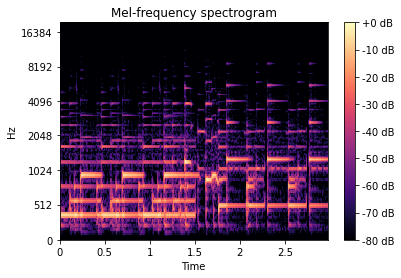

In [ ]:
#SHOW GRAPH. WE WILL USE PICTURES CREATED FROM MELODIES TO TRAIN VAE.
#THEN WE WILL CREATE PICTURES LIKE THIS AND TRANSFORM IT TO MELODY BY LIBROSA FUNCTION
fig, ax = plt.subplots()
S_dB = lb.power_to_db(test, ref=np.max)
img = lb_display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=44100,
                         fmax=20000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [ ]:
#ANOTHER OPTION HOW WE CAN USE PICTURE OF AUDIO SIGNAL FOR TRAIN NEURAL NETWORKS
test1=lb.feature.rms(y=test_file[0])

In [ ]:
test1.shape

(1, 450)

In [ ]:
ax.shape

(2,)

[Text(0.5, 1.0, 'log Power spectrogram')]

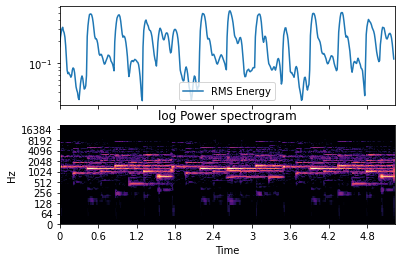

In [ ]:
S, phase = lb.magphase(lb.stft(test_file[0]))
fig, ax = plt.subplots(nrows=2, sharex=True)
times = lb.times_like(test1[0], sr=44100)
ax[0].semilogy(times, test1[0], label='RMS Energy')
ax[0].set(xticks=[])
ax[0].legend()
ax[0].label_outer()
lb.display.specshow(lb.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', sr=44100, ax=ax[1])
ax[1].set(title='log Power spectrogram')

In [ ]:
test_file.shape

(2, 220500)

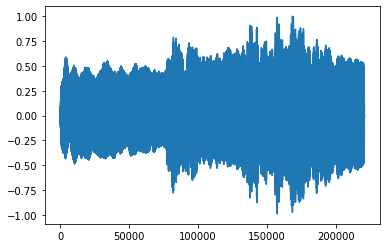

In [ ]:
#HOW SIGNAL LOOKS ON TIME SCALE
plt.plot(np.linspace(0,220500,220500), test_file[0])

In [4]:
#CREATE FUNCTION FOR LOADING ALL AUDIO FILES FROM DIRRECTORY
#RETURN NUMPY ARRAY OF SIGNAL, SAMPLE RATE AND LENGTH OF ARRAY
def music_loader(folder):
  import os
  mel_array=[]
  sp_array=[]
  lens=[]
  max_len=0
  for a in os.listdir(folder):
    mel, sp = lb.load(folder+str('/')+a, sr=44100, mono=False)
    mel_array.append(mel)
    sp_array.append(sp)
    lens.append(len(mel[0]))
  return mel_array, sp_array, lens

In [5]:
mel_array, sp_array, lens=music_loader(path_to_files)

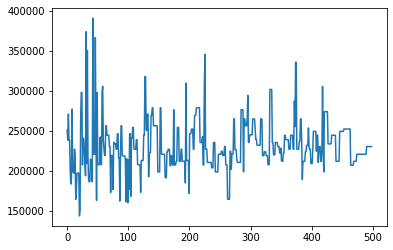

In [ ]:
#SHOW LENGTHS OF ALL ARRAYS
plt.plot(np.linspace(0,498,498), lens)

In [6]:
#CREATE TENSOR ARRAY FOR ADD DATA ONE PICTURE OF SIGNAL PER ONE ITTERATION
ta = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)

In [ ]:
#ADDING DATA AND REDUCE TO ONE SIZE
for i in range(len(mel_array)):
  if len(mel_array[i][0])>=262000:
    ta.write(i, tf.constant([
        lb.feature.melspectrogram(y=mel_array[i][0][0:262000], 
                                  n_mels=256, sr=44100, 
                                  hop_length=1024, 
                                  win_length=2048, 
                                  power=2.5, 
                                  fmin=20, 
                                  fmax=20000), 
                             lb.feature.melspectrogram(y=mel_array[i][1][0:262000], 
                                                       n_mels=256, 
                                                       sr=44100, 
                                                       fmin=20, 
                                                       fmax=20000, 
                                                       hop_length=1024, 
                                                       win_length=2048, 
                                                       power=2.5)]))
  else:
    nulls=np.zeros(262000-len(mel_array[i][0]), dtype=np.float32)
    ta.write(i, tf.constant([
        lb.feature.melspectrogram(y=np.append(mel_array[i][0], nulls), 
                                  n_mels=256, 
                                  sr=44100, 
                                  fmin=20, 
                                  fmax=20000,
                                  hop_length=1024, 
                                  win_length=2048, 
                                  power=2.5), 
                             lb.feature.melspectrogram(y=np.append(mel_array[i][1], nulls), 
                                                       n_mels=256, 
                                                       sr=44100, 
                                                       fmin=20, 
                                                       fmax=20000, 
                                                       hop_length=1024, 
                                                       win_length=2048, 
                                                       power=2.5)]))

In [30]:
#ADD LAST ELEMENTS FOR INITIALIZE NUMPY ARRAY
x_train = ta.read(497).numpy()[0].reshape((256,256,-1))
x_train=np.append(x_train, ta.read(497).numpy()[1].reshape((256,256,-1)), axis=2)

In [31]:
#RESHAPE DATA TO USABLE SIZE
x_train=x_train.reshape((-1,256,256,2))

In [32]:
#ADDING DATA IN NUMPY ARRAY IN USABLE SIZE AND NORMALIZE PER IMAGE
for i in range(ta.size().numpy()-1):
  x_timeless=ta.read(i).numpy()[0].reshape((256,256,-1))
  x_timeless=np.append(x_timeless, ta.read(i).numpy()[1].reshape((256,256,-1)), axis=2).reshape((-1,256,256,2))
  x_train=np.append(x_train, x_timeless, axis=0)

In [33]:
#NORMALIZE DATA
x_train=x_train-x_train.mean()
x_train=x_train/x_train.std()

In [34]:
x_train=x_train.reshape((498,-1,256,256,2))

In [35]:
#CREATE DATASET CONTAINING ALL PICTURES
dataset=tf.data.Dataset.from_tensor_slices(x_train)

In [36]:
#CREATE BATCHED DATASET
batched_dataset=dataset.batch(3)

In [ ]:
batched_dataset

<BatchDataset element_spec=TensorSpec(shape=(None, 1, 256, 256, 2), dtype=tf.float32, name=None)>

In [37]:
#CREATE VAE MODEL

#Sampling Class is a latent dimension of network
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

#Encoder receives pictures, that through convolutional layers go to latent dimension
class Encoder(layers.Layer):

    def __init__(self, latent_dim=2, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(256, 256, 2)),
            tf.keras.layers.Conv2D(
                filters=16, kernel_size=2, strides=(2, 2), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=2, strides=(2, 2), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=2, strides=(2, 2), activation='relu'),
            tf.keras.layers.GaussianDropout(rate=0.1),
            tf.keras.layers.Conv2D(
                filters=128, kernel_size=2, strides=(2, 2), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(
                filters=128, kernel_size=2, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
        ]
    )
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.encoder(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z


#Decoder recieve vector from latent dimension and return new picture
class Decoder(layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""

    def __init__(self, original_dim, latent_dim, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=1024, activation='relu'),
            tf.keras.layers.Dense(units=2048, activation='relu'),
            tf.keras.layers.Dense(units=4096, activation='relu'),
            tf.keras.layers.Dense(units=8192, activation='relu'),
            tf.keras.layers.Reshape(target_shape=(8, 8, 128)),
            tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=2, strides=(2, 2), padding='same',
                activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=2, strides=(2, 2), padding='same',
                activation='relu'),
            tf.keras.layers.GaussianDropout(rate=0.1),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=2, strides=(2, 2), padding='same',
                activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2DTranspose(
                filters=16, kernel_size=2, strides=(2, 2), padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=2, kernel_size=1, strides=2, padding='same'),
        ]
    )

    def call(self, inputs):
        x = self.decoder(inputs)
        return x


#Stack all components together
class VAEM(keras.Model):

    def __init__(
        self,
        original_dim,
        latent_dim=2,
        name="autoencoder",
        **kwargs
    ):
        super(VAEM, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(original_dim, latent_dim=latent_dim)

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        self.add_loss(kl_loss)
        return reconstructed

In [38]:
#CREATE SIZE OF MODEL
original_dim = [256,256,2]
vae = VAEM(original_dim, 4)

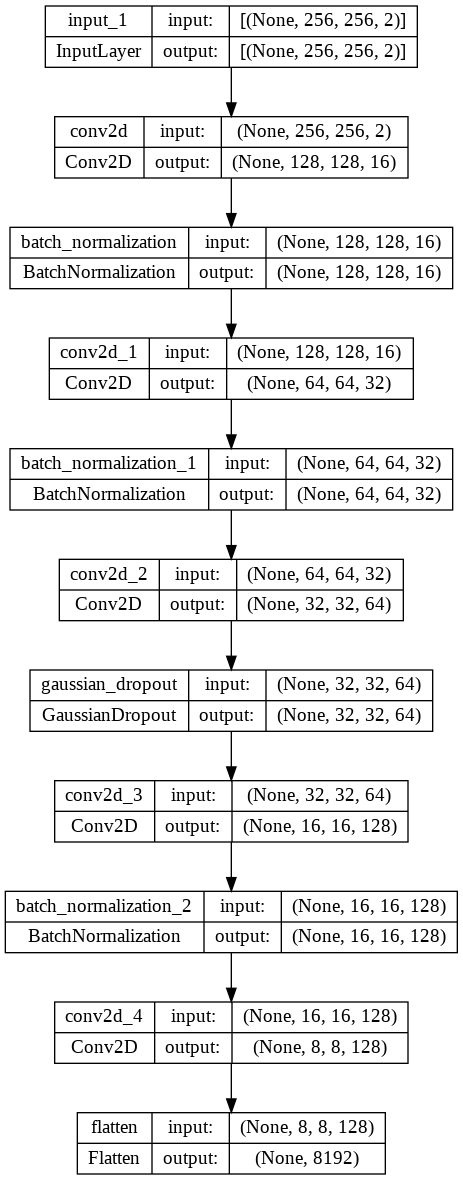

In [ ]:
#PLOT ENCODER SHAPE
tf.keras.utils.plot_model(vae.encoder.encoder, show_shapes=True)

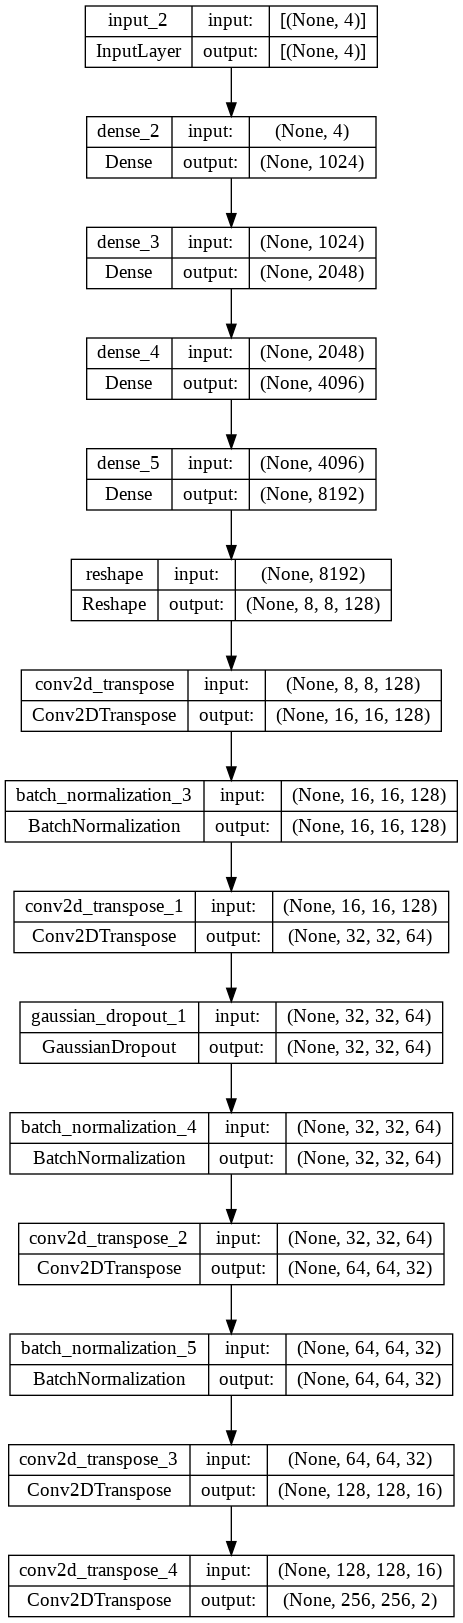

In [ ]:
#PLOT DECODER SHAPE
tf.keras.utils.plot_model(vae.decoder.decoder, show_shapes=True)

In [39]:
#DEFINE LOSS METRICS, OPTIMIZER AND LEARNING RATE
mse_loss_fn = tf.keras.losses.MeanSquaredError()
loss_metric = tf.keras.metrics.Mean()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [ ]:
#FIT NETWORK
epochs = 20

# Iterate over epochs.
for epoch in range(epochs):
    print("Start of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, x_batch_train in enumerate(dataset):
        with tf.GradientTape() as tape:
            reconstructed = vae(x_batch_train)
            # Compute reconstruction loss
            loss = mse_loss_fn(x_batch_train, reconstructed)
            loss += sum(vae.losses)  # Add KLD regularization loss

        grads = tape.gradient(loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))

        loss_metric(loss)

        if step % 5 == 0:
            print("step %d: mean loss = %.4f" % (step, loss_metric.result()))

In [77]:
#CREATE RANDOM TENSOR TO PASS IT THROUGH DECODER
a=tf.random.normal([4,4], 0, 10, tf.float32)

In [78]:
#INITIALIZE DECODER BY RANDOM TENSOR
samples=vae.decoder(a).numpy()

In [82]:
#TAKE SAMPLE FROM NETWORK OUTPUT
test_samp=samples[0][:][:][0]

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

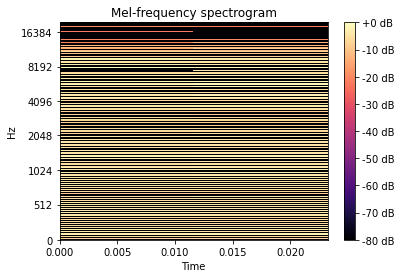

In [83]:
#PLOTING RESULT
#FOR NOW IT'S NOT PERFECT RESULT, BUT SOME PATTERN IS SHOWN ON THE PICTURE
#MAYBE I NEED TO CHANGE ARCHITECTURE OR INCREASE LAYERS AND TRAIN EPOCHS
fig, ax = plt.subplots()
S_dB = lb.power_to_db(test_samp, ref=np.max)
img = lb_display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=44100,
                         fmax=20000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')